# Example "analysis" workflow for SXS data
---

Developed using anaconda distribution of Python 3.11 including astropy. \
Use with Hitomi software and CalDB setup. Also uses pyxspec.

Data used is Hitomi Perseus Cluster (OBSID 100040030) data


# Downloading data and setting up directory structure

This demo uses Hitomi observations of the Perseus cluster ID 10040030

## Get data
```
wget -q -nH --no-check-certificate --cut-dirs=5 -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks (https://heasarc.gsfc.nasa.gov/FTP/hitomi/data/ob/1//100040030/sxs/)

wget -q -nH --no-check-certificate --cut-dirs=5 -r -l0 -c -N -np -R 'index*' -erobots=off --retr-symlinks (https://heasarc.gsfc.nasa.gov/FTP/hitomi/data/obs/1//100040030/auxil/)
```

## Get NXB files

```
mkdir NXB

cd NXB

wget (https://darts.jaxa.jp/pub/hitomi/data/nxb_20170510/ah_sxs_nxbafmar4_20140101v001.evt.gz)

wget (https://darts.jaxa.jp/pub/hitomi/data/nxb_20170510/ah_gen_nxbehk_20140101v002.fits.gz)

cd ..

```

### OR link data to working directory 

__Remember to set the working directory below__
```
ln -s /stage/headat/xrism/workshop/100040030 ./100040030
ln -s /stage/headat/xrism/workshop/NXB ./NXB
```


### Directory structures:  in the working directory:
```
100040030
NXB
products_sxs
```


## Jupyter setup

### i. imports 

---

In [1]:
import sys, os
from subprocess import check_call, Popen, PIPE
from astropy import log
import numpy as np
import math
from astropy.io import fits
#from xspec import *
import matplotlib.pyplot as plt

os.environ['HEADASNOQUERY']='1'

### ii. common heasoft defs

---

In [2]:
def runcmd(cmd):
    log.info('CMD: '+" ".join(cmd))
    log.info(cmd)
    check_call(cmd,env=os.environ)

def run_ftcopy(infile,ext,expr,outfile,copyall):
    copystr = "copyall=" + copyall
    if (expr.lower() == "none"):
        command = ["ftcopy","{0}[{1}]".format(infile,ext),outfile,copystr,"clobber=yes","history=yes"]
    else:
        command = ["ftcopy","{0}[{1}][{2}]".format(infile,ext,expr),outfile,copystr,"clobber=yes","history=yes"]
    runcmd(command)
    
def get_key(infile,extname,keyword):
    # Utility function for extracting FITS keywords
    hdulist = fits.open(infile)
    hdr = hdulist[extname].header
    hdulist.close()
    if (keyword in hdr):
        return(hdr[keyword])
    else:
        return("-1")

### iii. general hitomi defs

---

In [3]:
def filterfile(infile,outroot,pixels_to_use,itypes_to_use,addexpr):
    # Filters input event list on a list of pixels and grades.
    # For pixels_to_use = [-1] all pixels except pixel 12 are kept, for pixels_to_use = [] all pixels are kept.
    # For itype_to_use = [] all grades are kept.
    #
    # Build the ftcopy expression.
    pixexpr = ""
    grdexpr = ""
    totexpr = ""
    if (len(itypes_to_use) > 0):
        for ii in range(len(itypes_to_use)):
            if (ii == 0):
                grdexpr += "(ITYPE==" + str(itypes_to_use[ii])
            else:
                grdexpr += "||ITYPE==" + str(itypes_to_use[ii])
        grdexpr += ")"
    if (len(pixels_to_use)==1 and pixels_to_use[0]==-1):
        pixexpr += "(PIXEL!=12)"
    else:
        if (len(pixels_to_use) > 0):
            for ii in range(len(pixels_to_use)):
                if (ii == 0):
                    pixexpr += "(PIXEL==" + str(pixels_to_use[ii])
                else:
                    pixexpr += "||PIXEL==" + str(pixels_to_use[ii])
            pixexpr += ")"
    if (len(grdexpr) > 0):
        totexpr += grdexpr
        if (len(pixexpr) > 0):
            totexpr += ("&&"+pixexpr)
    else:
        if (len(pixexpr) > 0):
            totexpr += pixexpr
            
    if (len(totexpr) == 0): totexpr = "NONE"

    filtfile = outroot + "_filt.evt"
    run_ftcopy(infile,"EVENTS",totexpr,"tmpfiltfile.evt","yes")
    run_ftcopy("tmpfiltfile.evt","EVENTS",addexpr,filtfile,"yes")
    return(filtfile)


### iv. interface to heasoft

---


In [4]:
class taskpars:

    # The taskpars class consists of a task name, and a set of parameters of interest with default values in  
    # the form of a dictionary. With methods to initialize and update paramaters, and to run the tool, it
    # may be used to set up and run various ftools.
    def __init__(self,task,mydefaultpars):        
        self.task = task
        self.mydefaultpars = mydefaultpars
        self.pars = []
        self.values = []

    # Initialize the parameter values at their defaults.
    def initpars(self):
        self.pars = []
        self.values = []
        for key in self.mydefaultpars.keys():
            self.pars.append(key)
        for val in self.mydefaultpars.values():
            self.values.append(val)

    # Update a particular parameter with a particular value.
    def uppars(self,newpar,newval):
        idx = self.pars.index(newpar)
        self.values[idx] = newval

    # Construct the command string for a task with the current parameter settings, and run it.
    def runtask(self):
        command = []
        command.append(self.task)
        command_txt = self.task 
        for ii in range(len(self.mydefaultpars)):
            command.append(self.pars[ii] + '=' + self.values[ii])
            command_txt = command_txt + ' "' + self.pars[ii] + '=' + self.values[ii] + '"'
        command.append("clobber=yes")
        command_txt = command_txt + ' "clobber=yes"'
        runcmd(command)

---
### v. product extraction defs
---

In [5]:
def specextract(evtfile,specfile):
    # Extract a Hitomi SXS spectrum.
    extract_cmd = "extractor filename="+evtfile+" eventsout=NONE imgfile=NONE phafile="+specfile+" wtmapb=no fitsbinlc=NONE binlc=16.0 lcthresh=0.0 regionfile=NONE xcolf=ACTX ycolf=ACTY tcol=TIME ecol=PI xcolh=RAWX ycolh=RAWY timefile=NONE gtinam=GTI gti=GTI phamax=TLMAX xfkey=TLMAX yfkey=TLMAX xhkey=TLMAX yhkey=TLMAX clobber=yes"
    #print(extract_cmd)
    log.info(extract_cmd)
    os.system(extract_cmd)

In [6]:
def imgextract(evtfile,imgfile,coords):
    # Extract a Hitomi SXS image with user-defined coordinates - use DET, FOC, or SKY.
    if (coords.upper() == "SKY"): coords = ""
    extract_cmd = "extractor filename="+evtfile+" eventsout=NONE imgfile="+imgfile+" phafile=NONE wtmapb=no fitsbinlc=NONE binlc=64 lcthresh=1.0 regionfile=NONE xcolf="+coords+"X ycolf="+coords+"Y tcol=TIME ecol=PI xcolh=RAWX ycolh=RAWY timefile=NONE gtinam=GTI gti=GTI phamax=TLMAX xfkey=TLMAX yfkey=TLMAX xhkey=TLMAX yhkey=TLMAX clobber=yes"
    #print(extract_cmd)
    log.info(extract_cmd)
    os.system(extract_cmd)

In [7]:
def makeimage(infile,outfile,coords,emin,emax):
    # Make a simple image filtered on energy.
    imgexpr = "EPI2.GE." + str(emin) + "&&EPI2.LE." + str(emax)
    run_ftcopy(infile,"EVENTS",imgexpr,"img.evt","yes")
    imgextract("img.evt",outfile,coords)  

In [8]:
def lcextract(evtfile,lcfile,lcbinsize):
    # Extract a Hitomi SXS light curve with user-defined bins.
    extract_cmd = "extractor filename="+evtfile+" eventsout=NONE imgfile=NONE phafile=NONE wtmapb=no fitsbinlc="+lcfile+" binlc="+str(lcbinsize)+" lcthresh=1.0 regionfile=NONE xcolf=ACTX ycolf=ACTY tcol=TIME ecol=PI xcolh=RAWX ycolh=RAWY timefile=NONE gtinam=GTI gti=GTI phamax=TLMAX xfkey=TLMAX yfkey=TLMAX xhkey=TLMAX yhkey=TLMAX clobber=yes"
    #print(extract_cmd)
    log.info(extract_cmd)
    os.system(extract_cmd)


### vi. setup of spectra for PyXspec

---

In [9]:

class fitfiles:
    # Simple structure with spectrum and other information needed for fitting.
    def __init__(self,spec,back,rmf,arf,emin,emax):
        self.spec = spec
        self.back = back
        self.rmf = rmf
        self.arf = arf
        self.emin = emin
        self.emax = emax

### vii. setup of fitting in spectra for PyXspec

---

In [10]:
def xspec_set(files,plotname,hardcopy):
    # XSPEC plotting and fitting setup - the hardcopy=no option is untested.
    if (hardcopy.lower() == "yes"):
        Plot.device = plotname + "/cps"
    else:
        Plot.device = "/xs"
    Plot.xAxis = "keV"
    # Use these settings (bins must be at least 5-sigma, but no larger than 2 eV) for zooms on lines.
    #Plot.setRebin(5,4)
    #Plot.xLog = "no"
    #Plot.yLog = "no"
    # Use these settings (bins must be at least 20-sigma, but no larger than 40 eV) for a global look.
    Plot.setRebin(20,40)
    Plot.xLog = "yes"
    Plot.yLog = "yes"

    Plot.addCommand("setplot energy")
    Plot.addCommand("setplot lwidth 5")
    Plot.addCommand("setplot csize 1.2")
    Plot.addCommand("label top" + plotname)
    rescalex_exp = "setplot command rescale x " + str(files.emin) + " " + str(files.emax)
    Plot.addCommand(rescalex_exp)
    #rescaley_exp = "setplot command rescale y " + str(ymin) + " " + str(ymax)
    #Plot.addCommand(rescaley_exp)
    Plot.addCommand("time off")
    Plot.addCommand("log x")
    Plot.addCommand("log y")
    #Plot.addCommand("log x off")
    #Plot.addCommand("log y off")
    #Plot.addCommand("setplot rebin ")

    Xset.abund = "wilm"
    Xset.xsect = "vern"
    
    Fit.query = "yes"
    Fit.statMethod = "cstat"

### viii.  setting model for fit in PyXspec

In [11]:
def fit_pow(files,outallxcm,outmodxcm,hardcopy):
    # Procedure to conduct spectral fit to absorbed power-law, with NH fixed at G21 foreground value.
    # Plots the result, and saves the model command files.
    AllData.clear()
    AllModels.clear()
    spectrum = Spectrum(files.spec)
    spectrum.background = files.back
    spectrum.response = files.rmf
    spectrum.response.arf = files.arf
    # Expression defining energy band to fit:
    ignore_exp = "0.0-" + str(files.emin) + " "  + str(files.emax) + "-**" 
    spectrum.ignore(ignore_exp)
    # Build the model expression.
    mymodel = "TBabs*powerlaw"       
    #print(mymodel)
    # Define the model.
    xspec_model = Model(mymodel)
    plaw = xspec_model.powerlaw
    plaw.PhoIndex.values = "1,0.01,-3,-2,9,10"
    plaw.norm.values = "0.000001,0.01,0,0,1e+20,1.0e+20"
    abs = xspec_model.TBabs
    abs.nH.values = "3.0,0.01,0,0,1.0e+5,1.0e+6"
    abs.nH.frozen = "yes"

    xspec_model
    Model.show(xspec_model)
    # Fit the model.
    Fit.nIterations = 1000
    Fit.renorm()
    Fit.perform()
    #dof = Fit.dof
    #cstat = Fit.statistic

    rate = spectrum.rate[0]
    plawfit = plaw.PhoIndex.values[0]
    fluxstr = str(files.emin) + " " + str(files.emax)
    AllModels.calcFlux(fluxstr)
    flux = spectrum.flux

    # Save the "xcm" files.
    if os.path.isfile(outallxcm): os.remove(outallxcm)
    if os.path.isfile(outmodxcm): os.remove(outmodxcm)
    Xset.save(outallxcm,info='a')
    Xset.save(outmodxcm,info='m')
    # Make the plots.
    if (hardcopy.lower() == "yes"):
        Plot("data,ratio")
        #Plot("data,residuals")
    else:
        # Plot ratio for global look, residuals for zoom on line regions.
        Plot.iplot("data,ratio")
        #Plot.iplot("data,residuals")
    return(rate,plawfit,flux)    

In [12]:
def plotset(tstring,xstring,ystring,xmin,xmax,ymin,ymax):
    plt.clf()
    plt.title(tstring)
    plt.xlabel(xstring,fontsize=10)
    plt.ylabel(ystring,fontsize=10)
    if (xmin<xmax): plt.xlim(xmin,xmax)
    if (ymin<ymax): plt.ylim(ymin,ymax)
        
def lcplot(infile,emin,emax,lcbin,outroot):
    # Make a simple light curve, filtered on energy, and plot the output.
    lcexpr = "EPI2.GE." + str(emin) + "&&EPI2.LE." + str(emax)
    run_ftcopy(infile,"EVENTS",lcexpr,"lc.evt","yes")
    lcextract("lc.evt","lc.lc",lcbin)
    hdulist = fits.open("lc.lc")
    time = hdulist["RATE"].data.field("TIME")
    rate = hdulist["RATE"].data.field("RATE")
    drate = hdulist["RATE"].data.field("ERROR")
    hdulist.close()
    #tmax = time[np.size(time)-1] - time[0]
    plotset('','time (sec)','rate (ct/s)',-1,-1,-1,-1)
    plt.errorbar(time,rate,xerr=0.5*lcbin,yerr=drate,fmt='.',color='r',linewidth=1,label='')
    plt.savefig(outroot+".lc.png")

### ix. Pixel map setup

In [13]:
def plotpxdist(infile,emin,emax,outroot):
    # Make a pixel map, filtered on energy, and plot the output.
    expr = "EPI2.GE." + str(emin) + "&&EPI2.LE." + str(emax)
    run_ftcopy(infile,"EVENTS",expr,"pix.evt","yes")
    hdulist = fits.open("pix.evt")
    pixel = hdulist["EVENTS"].data.field("PIXEL")
    hdulist.close()
    # Diagnostic plots for pixel distribution:
    npixel = 36
    map_num = np.zeros((6,6),dtype=float)
    map_id = np.zeros((6,6),dtype=float)
    img = np.zeros((6,6),dtype=float)
    x = [2,0,1,0,1,0,1,2,2,5,4,5,5,4,4,3,3,3,3,5,4,5,4,5,4,3,3,0,1,0,0,1,1,2,2,2]
    y = [2,2,2,1,1,0,0,1,0,2,2,1,0,1,0,1,0,2,3,3,3,4,4,5,5,4,5,3,3,4,5,4,5,4,5,3]
    for ipix in range(npixel):
        pixcount = np.size(np.where(pixel==ipix)[0])
        ii =  x[ipix]
        jj = 5 - y[ipix]
        kk = y[ipix]
        map_num[ii,jj] = pixcount
        map_id[ii,jj] = ipix
        img[jj,ii] =  pixcount
    fig, ax = plt.subplots()
    minval = 0.9 * np.min(map_num[np.where(map_num>0.0)])
    maxval = 1.1 * np.max(map_num[np.where(map_num>0.0)])
    im = ax.imshow(img,vmin=minval,vmax=maxval,cmap='CMRmap')
    for ii in range(6):
        for jj in range(6):
            text = ax.text(ii, jj, map_id[ii, jj].astype(int), ha="center", va="center", color="w", size="small")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Pixel ID")
    plt.savefig(outroot+"pixidmap.png",format='png')
    plt.show()
    plt.clf()
    fig, ax = plt.subplots()
    im = ax.imshow(img,vmin=minval,vmax=maxval,cmap="CMRmap")
    for ii in range(6):
        for jj in range(6):
            text = ax.text(ii, jj, map_num[ii, jj].astype(int), ha="center", va="center", color="w", size="small")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Pixel Distribution")
    plt.savefig(outroot+"pixnummap.png",format='png')
    plt.show()
    plt.clf()

---

# 1.  Data screening

---



## 1.1  Data directories and names

__Remember to set the working directory__

---

In [14]:
# Input event file and root for all output files (logs, filtered events, plots, xspec commands, response files).

#define the full path to the working directory 
wdir = "./"

#define path to products directory

proddir = wdir + "/products_sxs/"

# 
evtfile = wdir+"100040030/sxs/event_cl/ah100040030sxs_p0px1010_cl.evt.gz"

#outroot
outroot = proddir + "ah100040030sxs"
# Also the mkffile, ehk, and lost GTI files for needed for ARF generation. 
mkffile = wdir+ "100040030/auxil/ah100040030.mkf.gz"
ehkfile = wdir+"100040030/auxil/ah100040030.ehk.gz"
lostgtifile = wdir+"100040030/sxs/event_uf/ah100040030sxs_el.gti.gz"

In [15]:
# Pixels to use - used for spectrum and response.
# Specify pixels_to_use = [-1] for all pixels except pixel 12, pixels_to_use = [] for all pixels.
pixels_to_use = [-1]


In [16]:
# Grades to use - used for spectrum and response.
# Specify itype_to_use = [] for all grades.
# Use Hp and Mp only [0,1].
itypes_to_use = [0,1,2,3]

In [17]:
# If harcopy = yes, make postscript output, otherwise leave in interactive plotting (not sure if this works).
hardcopy = "yes"
# Energy (keV) range for spectral fitting:
emin = 2.0
emax = 12.0

## 1.2  Screening on event quality and grade
    
    -Filter the file on grade and pixel in preparation for spectral extraction
    -Expression below:  PI = pulse ??,  Rise_Time  not too fast not too slow,  ITYPE = grade 0, 1 H, Mp

In [18]:
# Filter the file on grade and pixel in preparation for spectral extraction
# The additional expression is the standard one that was used on Hitomi.
addexpr = "(PI>=400)&&((RISE_TIME>=40&&RISE_TIME<=60&&ITYPE<4)||(ITYPE==4))&&STATUS[4]==b0"
#filtfile = filterfile(evtfile,outroot,pixels_to_use,itypes_to_use,addexr)
cl2file = outroot + "_p0px1010_cl2.evt"
run_ftcopy(evtfile,"EVENTS",addexpr,cl2file,"yes")

INFO: CMD: ftcopy ./100040030/sxs/event_cl/ah100040030sxs_p0px1010_cl.evt.gz[EVENTS][(PI>=400)&&((RISE_TIME>=40&&RISE_TIME<=60&&ITYPE<4)||(ITYPE==4))&&STATUS[4]==b0] .//products_sxs/ah100040030sxs_p0px1010_cl2.evt copyall=yes clobber=yes history=yes [unknown]
INFO: ['ftcopy', './100040030/sxs/event_cl/ah100040030sxs_p0px1010_cl.evt.gz[EVENTS][(PI>=400)&&((RISE_TIME>=40&&RISE_TIME<=60&&ITYPE<4)||(ITYPE==4))&&STATUS[4]==b0]', './/products_sxs/ah100040030sxs_p0px1010_cl2.evt', 'copyall=yes', 'clobber=yes', 'history=yes'] [unknown]


---

# 2 Image Extraction

---

In [19]:
# Make an image in SKY coordinates in the 2-10 keV band.
# This could also be done using ds9 or ximage to display a sky image extracted with xselect using the file 
# xselect.mdb.xrism available here:
# https://xrsrv1.isas.jaxa.jp/confluence/display/XINTL/XRISM+SDC+Tools+Pre-launch+Builds
emin = 2000.0
emax = 10000.0
# Make an image in SKY coordinates
makeimage(cl2file,outroot+"_p0px1010_cl2_SKY.img","SKY",emin,emax)

# Make an image in DET coordinates
makeimage(cl2file,outroot+"_p0px1010_cl2_DET.img","DET",emin,emax)

INFO: CMD: ftcopy .//products_sxs/ah100040030sxs_p0px1010_cl2.evt[EVENTS][EPI2.GE.2000.0&&EPI2.LE.10000.0] img.evt copyall=yes clobber=yes history=yes [unknown]
INFO: ['ftcopy', './/products_sxs/ah100040030sxs_p0px1010_cl2.evt[EVENTS][EPI2.GE.2000.0&&EPI2.LE.10000.0]', 'img.evt', 'copyall=yes', 'clobber=yes', 'history=yes'] [unknown]
INFO: extractor filename=img.evt eventsout=NONE imgfile=.//products_sxs/ah100040030sxs_p0px1010_cl2_SKY.img phafile=NONE wtmapb=no fitsbinlc=NONE binlc=64 lcthresh=1.0 regionfile=NONE xcolf=X ycolf=Y tcol=TIME ecol=PI xcolh=RAWX ycolh=RAWY timefile=NONE gtinam=GTI gti=GTI phamax=TLMAX xfkey=TLMAX yfkey=TLMAX xhkey=TLMAX yhkey=TLMAX clobber=yes [unknown]
extractor v6.10    20 Jan 2023
 Getting FITS WCS Keywords
 Doing file: img.evt
100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         125353    125353            0         0         0         0
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
       

## 2.1 Pixel Images

---

INFO: CMD: ftcopy .//products_sxs/ah100040030sxs_p0px1010_cl2.evt[EVENTS][EPI2.GE.2000.0&&EPI2.LE.12000.0] pix.evt copyall=yes clobber=yes history=yes [unknown]
INFO: ['ftcopy', './/products_sxs/ah100040030sxs_p0px1010_cl2.evt[EVENTS][EPI2.GE.2000.0&&EPI2.LE.12000.0]', 'pix.evt', 'copyall=yes', 'clobber=yes', 'history=yes'] [unknown]


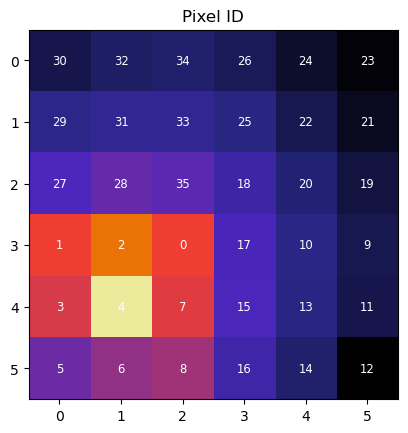

<Figure size 640x480 with 0 Axes>

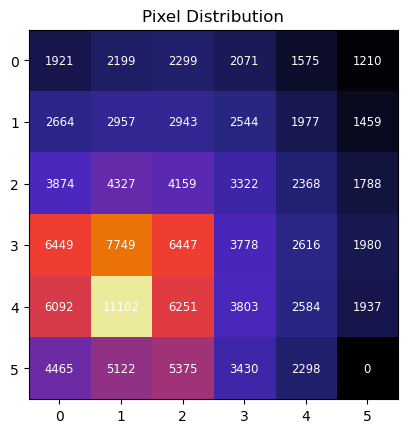

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot the pixel distribution heat map,showing (1) Pixel ID map and (2) Number of events. 
# Hardcopies are also made.
# This could also be done using ds9 or ximage to display a DET image extracted with xselect using the file 
# xselect.mdb.xrism available here:
# https://xrsrv1.isas.jaxa.jp/confluence/display/XINTL/XRISM+SDC+Tools+Pre-launch+Builds
emin = 2000.0
emax = 12000.0
plotpxdist(cl2file,emin,emax,outroot)

## 2.2 Viewing sky image

---

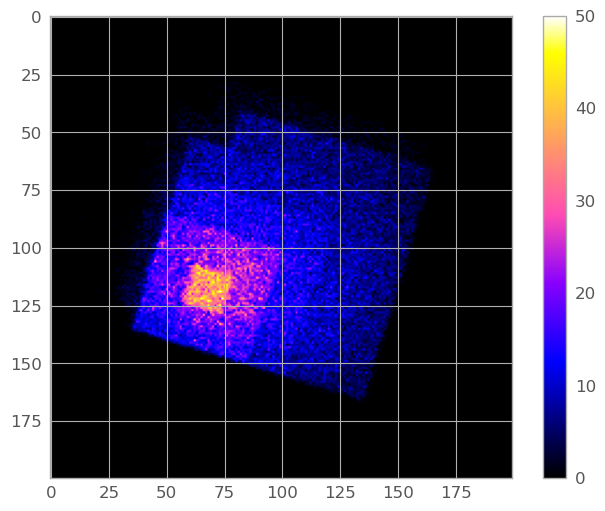

<Figure size 800x600 with 0 Axes>

In [21]:
# Plot the sky image in the standard orientation. May need to adjust the color map.
# A hardcopy is also made.
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
image_file = get_pkg_data_filename(outroot+"_p0px1010_cl2_SKY.img")
#fits.info(image_file)
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)
subimage_data = (np.flipud(image_data[1115:1315,1115:1315]))
plt.figure()
plt.imshow(subimage_data, cmap='gnuplot2')
plt.colorbar()
plt.savefig(outroot+"skyimg.png",format='png')
plt.show()
plt.clf()

##  2.3 create region files

View extracted .img files in ds9 and add regions.

`ds9 ah100040030sxs_p0px1010_SKY.img`

`ahmkregion` makes region files for DET,ACT and SKY coords.

In [22]:
ra=get_key(cl2file,"EVENTS","RA_NOM")
dec=get_key(cl2file,"EVENTS","DEC_NOM")
roll=get_key(cl2file,"EVENTS","PA_NOM")
if roll > 180: roll -= 360
print(ra,dec,roll)

ahregioncmd = f"ahmkregion SXS {ra} {dec} {roll}"
print(ahregioncmd)

os.system(ahregioncmd)

49.9324156058081 41.5201310551332 -106.93604892357999
ahmkregion SXS 49.9324156058081 41.5201310551332 -106.93604892357999
INFO   ::Starting.
INFO   ::
INFO   ::===========================================================
INFO   ::                Running ahmkregion
INFO   ::===========================================================
INFO   ::
INFO   :: 
INFO   ::START PARAMETER list for ahmkregion
INFO   :: ahmkregion 'instrume=SXS' 'ra=49.9324156058081' 'dec=41.5201310551332' 'roll=-106.93604892357999' 'teldeffile=CALDB' 'inregion=NONE' 'outroot=NONE' 'pixlist=0-35' 'outtextregion=yes' 'outxco=yes' 'cleanup=yes' 'history=yes' 'clobber=yes' 'chatter=2' 'logfile=!DEFAULT' 'debug=no' 'mode=ql'
INFO   ::END PARAMETER list for ahmkregion
INFO   :: 
INFO   ::
INFO   ::FTOOLS CMD: coordpnt 'telescop=HITOMI' 'instrume=SXS' 'ra=49.9324156058081' 'dec=41.5201310551332' 'roll=-106.93604892357999' 'teldeffile=CALDB' 'startsys=ACT' 'input=SXS.ACT.box.reg' 'clobber=yes' 'outfile=SXS.DET.box.reg' 'st

0

## 2.4  Create region encircling detector footprint.

### Region coverning all data

- Define the center of the array and circumscribe a circle.
- This region will be used to extract all the events.
- This will make lightcurves, maps and spectra

In [23]:

hdu=fits.open(cl2file)
ra   = hdu[1].header["RA_NOM"]
dec  = hdu[1].header["DEC_NOM"]
roll = hdu[1].header["PA_NOM"]

In [24]:
coordpnt = taskpars("coordpnt",{"input":"NONE","outfile":"tempfile","telescop":"HITOMI","instrume":"SXS", \
                              "ra":f"{ra}","dec":f"{dec}","roll":f"{roll}", "startsys":"det","stopsys":"radec"})
coordpnt.initpars()
coordpnt.uppars("input","3.5,3.5")
coordpnt.runtask()


INFO: CMD: coordpnt input=3.5,3.5 outfile=tempfile telescop=HITOMI instrume=SXS ra=49.9324156058081 dec=41.5201310551332 roll=253.06395107642 startsys=det stopsys=radec clobber=yes [unknown]
INFO: ['coordpnt', 'input=3.5,3.5', 'outfile=tempfile', 'telescop=HITOMI', 'instrume=SXS', 'ra=49.9324156058081', 'dec=41.5201310551332', 'roll=253.06395107642', 'startsys=det', 'stopsys=radec', 'clobber=yes'] [unknown]
coordpnt: OUTX OUTY=   49.93350633    41.52159242


In [25]:
ra_center=49.93217936
dec_center=41.51846637
radius=150.0/3600.0

# write this to a region file
#
f = open(wdir+"/products_sxs/perseus_offset_sky.reg",'w')
f.write("# Region file \n")
f.write("fk5 \n")
line=f"circle({ra_center},{dec_center},{radius}) \n"
f.write(line)
f.close()

# 3. Full-array data

## 3.1 Extract products from region file


This will extract a spectrum, image and lightcurve for all events within the region.

---

In [26]:
sxsregext = taskpars("sxsregext",{"infile":"NONE","regmode":"RADEC","region":"NONE", \
                                  "resolist":"0","outroot":"NONE","outexp":"NONE","ehkfile":"NONE", \
                                  "delta":"20","numphi":"1"})
sxsregext.initpars()


In [27]:
sxsregext.uppars("infile",cl2file)
sxsregext.uppars("region",proddir + "perseus_offset_sky.reg")
sxsregext.uppars("outroot",outroot+"_detreg")
sxsregext.uppars("outexp",outroot+".expo")
sxsregext.uppars("ehkfile",ehkfile)

sxsregext.runtask()

INFO: CMD: sxsregext infile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt regmode=RADEC region=.//products_sxs/perseus_offset_sky.reg resolist=0 outroot=.//products_sxs/ah100040030sxs_detreg outexp=.//products_sxs/ah100040030sxs.expo ehkfile=./100040030/auxil/ah100040030.ehk.gz delta=20 numphi=1 clobber=yes [unknown]
INFO: ['sxsregext', 'infile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt', 'regmode=RADEC', 'region=.//products_sxs/perseus_offset_sky.reg', 'resolist=0', 'outroot=.//products_sxs/ah100040030sxs_detreg', 'outexp=.//products_sxs/ah100040030sxs.expo', 'ehkfile=./100040030/auxil/ah100040030.ehk.gz', 'delta=20', 'numphi=1', 'clobber=yes'] [unknown]
INFO   ::Starting.
INFO   ::
INFO   ::===========================================================
INFO   ::                Running sxsregext
INFO   ::===========================================================
INFO   ::
INFO   :: 
INFO   ::START PARAMETER list for sxsregext
INFO   :: sxsregext 'infile=.//products_sxs/ah10004003

## 3.2 Show Light Curve

In [28]:
#filter for grade Hp itype = 0
itypes_to_use=[0]
filtfile = filterfile(cl2file,outroot,pixels_to_use,itypes_to_use,addexpr)

INFO: CMD: ftcopy .//products_sxs/ah100040030sxs_p0px1010_cl2.evt[EVENTS][(ITYPE==0)&&(PIXEL!=12)] tmpfiltfile.evt copyall=yes clobber=yes history=yes [unknown]
INFO: ['ftcopy', './/products_sxs/ah100040030sxs_p0px1010_cl2.evt[EVENTS][(ITYPE==0)&&(PIXEL!=12)]', 'tmpfiltfile.evt', 'copyall=yes', 'clobber=yes', 'history=yes'] [unknown]
INFO: CMD: ftcopy tmpfiltfile.evt[EVENTS][(PI>=400)&&((RISE_TIME>=40&&RISE_TIME<=60&&ITYPE<4)||(ITYPE==4))&&STATUS[4]==b0] .//products_sxs/ah100040030sxs_filt.evt copyall=yes clobber=yes history=yes [unknown]
INFO: ['ftcopy', 'tmpfiltfile.evt[EVENTS][(PI>=400)&&((RISE_TIME>=40&&RISE_TIME<=60&&ITYPE<4)||(ITYPE==4))&&STATUS[4]==b0]', './/products_sxs/ah100040030sxs_filt.evt', 'copyall=yes', 'clobber=yes', 'history=yes'] [unknown]


INFO: CMD: ftcopy .//products_sxs/ah100040030sxs_filt.evt[EVENTS][EPI2.GE.2000&&EPI2.LE.15000] lc.evt copyall=yes clobber=yes history=yes [unknown]
INFO: ['ftcopy', './/products_sxs/ah100040030sxs_filt.evt[EVENTS][EPI2.GE.2000&&EPI2.LE.15000]', 'lc.evt', 'copyall=yes', 'clobber=yes', 'history=yes'] [unknown]
INFO: extractor filename=lc.evt eventsout=NONE imgfile=NONE phafile=NONE wtmapb=no fitsbinlc=lc.lc binlc=60 lcthresh=1.0 regionfile=NONE xcolf=ACTX ycolf=ACTY tcol=TIME ecol=PI xcolh=RAWX ycolh=RAWY timefile=NONE gtinam=GTI gti=GTI phamax=TLMAX xfkey=TLMAX yfkey=TLMAX xhkey=TLMAX yhkey=TLMAX clobber=yes [unknown]
extractor v6.10    20 Jan 2023
 Getting FITS WCS Keywords
 Doing file: lc.evt
100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         126027    126027            0         0         0         0
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         126027    126027            0         0         0         0
   in 

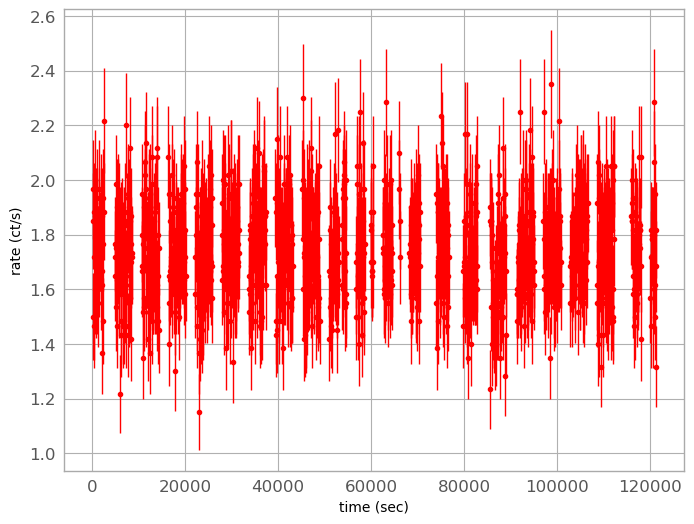

In [29]:
lcplot(filtfile,2000,15000,60,outroot+"_lc")


## 3.3 Extract Spectrum

In [30]:
spectfile = outroot+"_p0px1010_cl2_HP.pi"

specextract(filtfile,spectfile)

INFO: extractor filename=.//products_sxs/ah100040030sxs_filt.evt eventsout=NONE imgfile=NONE phafile=.//products_sxs/ah100040030sxs_p0px1010_cl2_HP.pi wtmapb=no fitsbinlc=NONE binlc=16.0 lcthresh=0.0 regionfile=NONE xcolf=ACTX ycolf=ACTY tcol=TIME ecol=PI xcolh=RAWX ycolh=RAWY timefile=NONE gtinam=GTI gti=GTI phamax=TLMAX xfkey=TLMAX yfkey=TLMAX xhkey=TLMAX yhkey=TLMAX clobber=yes [unknown]
extractor v6.10    20 Jan 2023
 Getting FITS WCS Keywords
 Doing file: .//products_sxs/ah100040030sxs_filt.evt
100% completed
          Total      Good    Bad: Time     Phase     Grade       Cut
         128386    128386            0         0         0         0
    Grand Total      Good    Bad: Time     Phase     Grade       Cut
         128386    128386            0         0         0         0
   in  72512.     seconds
 Spectrum         has   127991 counts for   1.765     counts/sec
 ... wrote the PHA data Extension


# 4. NXB spectrum

In [31]:
sxsnxbgen = taskpars("sxsnxbgen",{"infile":"NONE","ehkfile":"NONE","regfile":"NONE","innxbfile":"NONE", \
                                 "innxbehk":"NONE","outpifile":"NONE","pixels":"-","cleanup":"yes","chatter":"3", \
                                 "mode":"hl","logfile":"NONE","sortbin":"NONE","expr":"NONE"})
sxsnxbgen.initpars()


In [32]:
sxsnxbgen.uppars("infile",cl2file)
sxsnxbgen.uppars("ehkfile",ehkfile)
sxsnxbgen.uppars("innxbfile",wdir+"/NXB/ah_sxs_nxbafmar4_20140101v001.evt.gz")
sxsnxbgen.uppars("innxbehk",wdir+"/NXB/ah_gen_nxbehk_20140101v002.fits.gz")
sxsnxbgen.uppars("outpifile",outroot+"nxb_cl2.pi")
sxsnxbgen.uppars("logfile",outroot+"nxb_cl2.log")
sxsnxbgen.uppars("sortbin","0,4,5,6,7,8,9,10,11,12,13,99")
sxsnxbgen.uppars("expr","PI>=400&&RISE_TIME>=40&&RISE_TIME<=60&&ITYPE<4&&STATUS[4]==b0")

sxsnxbgen.runtask()

INFO: CMD: sxsnxbgen infile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt ehkfile=./100040030/auxil/ah100040030.ehk.gz regfile=NONE innxbfile=.//NXB/ah_sxs_nxbafmar4_20140101v001.evt.gz innxbehk=.//NXB/ah_gen_nxbehk_20140101v002.fits.gz outpifile=.//products_sxs/ah100040030sxsnxb_cl2.pi pixels=- cleanup=yes chatter=3 mode=hl logfile=.//products_sxs/ah100040030sxsnxb_cl2.log sortbin=0,4,5,6,7,8,9,10,11,12,13,99 expr=PI>=400&&RISE_TIME>=40&&RISE_TIME<=60&&ITYPE<4&&STATUS[4]==b0 clobber=yes [unknown]
INFO: ['sxsnxbgen', 'infile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt', 'ehkfile=./100040030/auxil/ah100040030.ehk.gz', 'regfile=NONE', 'innxbfile=.//NXB/ah_sxs_nxbafmar4_20140101v001.evt.gz', 'innxbehk=.//NXB/ah_gen_nxbehk_20140101v002.fits.gz', 'outpifile=.//products_sxs/ah100040030sxsnxb_cl2.pi', 'pixels=-', 'cleanup=yes', 'chatter=3', 'mode=hl', 'logfile=.//products_sxs/ah100040030sxsnxb_cl2.log', 'sortbin=0,4,5,6,7,8,9,10,11,12,13,99', 'expr=PI>=400&&RISE_TIME>=40&&RISE_TIME<=60&

# 5. Response Files

## 5.1 RMF

In [33]:
sxsmkrmf = taskpars("sxsmkrmf",{"infile":"NONE","outfile":"NONE","resolist":"0","regmode":"det","regionfile":"NONE","whichrmf":"m"})
sxsmkrmf.initpars()

sxsmkrmf.uppars("infile",cl2file)
sxsmkrmf.uppars("outfile",outroot+"_cl2_HP_small.rmf")
sxsmkrmf.uppars("regionfile",outroot+"_detreg.reg")

sxsmkrmf.runtask()

INFO: CMD: sxsmkrmf infile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt outfile=.//products_sxs/ah100040030sxs_cl2_HP_small.rmf resolist=0 regmode=det regionfile=.//products_sxs/ah100040030sxs_detreg.reg whichrmf=m clobber=yes [unknown]
INFO: ['sxsmkrmf', 'infile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt', 'outfile=.//products_sxs/ah100040030sxs_cl2_HP_small.rmf', 'resolist=0', 'regmode=det', 'regionfile=.//products_sxs/ah100040030sxs_detreg.reg', 'whichrmf=m', 'clobber=yes'] [unknown]
INFO   ::
INFO   ::FTOOLS CMD: quzcif 'MISSION=HITOMI' 'INSTRUMENT=SXS' 'DETECTOR=-' 'FILTER=-' 'CODENAME=TELDEF' 'DATE=2016-03-04' 'TIME=02:17:32' 'EXPR=-' 'MAXRET=1' 'RETRIEVE=no'
INFO   ::/home/idies/workspace/headata/FTP/caldb/data/hitomi/sxs/bcf/teldef/ah_sxs_teldef_20140101v002.fits 0
INFO   ::
INFO   ::
INFO   ::FTOOLS CMD: ftverify '/home/idies/workspace/headata/FTP/caldb/data/hitomi/sxs/bcf/teldef/ah_sxs_teldef_20140101v002.fits[0]' 'errreport=e' 'prstat=no'
INFO   ::verification OK: /h

## 5.2 Recalculate exposure map

In [34]:
ahexpmap = taskpars("ahexpmap",{"ehkfile":"NONE","gtifile":"NONE","instrume":"SXS","badimgfile":"NONE",\
                                "pixgtifile":"NONE","outfile":"NONE","outmaptype":"EXPOSURE","delta":"20.0",\
                                "numphi":"1","stopsys":"SKY","instmap":"CALDB","qefile":"CALDB",\
                                "contamifile":"CALDB","vigfile":"CALDB","obffile":"CALDB","fwfile":"CALDB",\
                                "gvfile":"CALDB","maskcalsrc":"yes","fwtype":"DEFAULT","specmode":"MONO",\
                               "specfile":"spec.fits","specform":"FITS","energy":"1.5","evperchan":"DEFAULT",\
                               "abund":"1","cols":"0","covfac":"1","chatter":"1","logfile":"NONE"})
ahexpmap.initpars()

ahexpmap.uppars("ehkfile",ehkfile)
ahexpmap.uppars("gtifile",cl2file)
ahexpmap.uppars("pixgtifile",wdir + "/100040030/sxs/event_uf/ah100040030sxs_px1010_exp.gti.gz")
ahexpmap.uppars("outfile",outroot+"_p0px1010.expo")
ahexpmap.uppars("logfile",wdir + "/100040030/products_sxs/make_expo_ah100040030sxs_p0px1010.log")

ahexpmap.runtask()

INFO: CMD: ahexpmap ehkfile=./100040030/auxil/ah100040030.ehk.gz gtifile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt instrume=SXS badimgfile=NONE pixgtifile=.//100040030/sxs/event_uf/ah100040030sxs_px1010_exp.gti.gz outfile=.//products_sxs/ah100040030sxs_p0px1010.expo outmaptype=EXPOSURE delta=20.0 numphi=1 stopsys=SKY instmap=CALDB qefile=CALDB contamifile=CALDB vigfile=CALDB obffile=CALDB fwfile=CALDB gvfile=CALDB maskcalsrc=yes fwtype=DEFAULT specmode=MONO specfile=spec.fits specform=FITS energy=1.5 evperchan=DEFAULT abund=1 cols=0 covfac=1 chatter=1 logfile=.//100040030/products_sxs/make_expo_ah100040030sxs_p0px1010.log clobber=yes [unknown]
INFO: ['ahexpmap', 'ehkfile=./100040030/auxil/ah100040030.ehk.gz', 'gtifile=.//products_sxs/ah100040030sxs_p0px1010_cl2.evt', 'instrume=SXS', 'badimgfile=NONE', 'pixgtifile=.//100040030/sxs/event_uf/ah100040030sxs_px1010_exp.gti.gz', 'outfile=.//products_sxs/ah100040030sxs_p0px1010.expo', 'outmaptype=EXPOSURE', 'delta=20.0', 'numphi=1', 'st

## 5.3 ARF file

- NOTE: this script assumes that the target is point source.
- You should read the "step by step guide" and the published paper (e.g. Hitomi collaboration 2018, PASJ, 70, 9)

In [35]:
# Define/initialize aharfgen
aharfgen = taskpars("aharfgen",{"xrtevtfile":"NONE","source_ra":"RA","source_dec":"DEC","telescop":"HITOMI", \
                               "instrume":"SXS","emapfile":"NONE","regmode":"DET","regionfile":"NONE", \
                               "sourcetype":"POINT","rmffile":"NONE","erange":"0.5 17.0 0 0", \
                               "outfile":"NONE", "numphoton":"300000","minphoton":"1", \
                               "teldeffile":"CALDB","qefile":"CALDB","contamifile":"CALDB","obffile":"CALDB", \
                               "fwfile":"CALDB","gatevalvefile":"CALDB","onaxisffile":"CALDB", \
                               "onaxiscfile":"CALDB","mirrorfile":"CALDB","obstructfile":"CALDB", \
                               "frontreffile":"CALDB","backreffile":"CALDB","pcolreffile":"CALDB", \
                               "scatterfile":"CALDB","auxtransfile":"NONE",\
                               "mode":"h","seed":"7","logfile":"NONE"})

aharfgen.initpars()

In [36]:
aharfgen.uppars("xrtevtfile",proddir+"raytrace_ah100040030sxs_p0px1010_ptsrc.fits")
aharfgen.uppars("source_ra","49.9507")
aharfgen.uppars("source_dec","41.5128")
aharfgen.uppars("emapfile",outroot+"_p0px1010.expo")
aharfgen.uppars("regionfile",outroot+"_detreg.reg")
aharfgen.uppars("rmffile",outroot+"_cl2_HP_small.rmf")
aharfgen.uppars("outfile",outroot+"_p0px1010_ptsrc.arf")
aharfgen.uppars("logfile",proddir + "make_arf_ah100040030sxs_p0px1010_ptsrc.log")

aharfgen.runtask()

INFO: CMD: aharfgen xrtevtfile=.//products_sxs/raytrace_ah100040030sxs_p0px1010_ptsrc.fits source_ra=49.9507 source_dec=41.5128 telescop=HITOMI instrume=SXS emapfile=.//products_sxs/ah100040030sxs_p0px1010.expo regmode=DET regionfile=.//products_sxs/ah100040030sxs_detreg.reg sourcetype=POINT rmffile=.//products_sxs/ah100040030sxs_cl2_HP_small.rmf erange=0.5 17.0 0 0 outfile=.//products_sxs/ah100040030sxs_p0px1010_ptsrc.arf numphoton=300000 minphoton=1 teldeffile=CALDB qefile=CALDB contamifile=CALDB obffile=CALDB fwfile=CALDB gatevalvefile=CALDB onaxisffile=CALDB onaxiscfile=CALDB mirrorfile=CALDB obstructfile=CALDB frontreffile=CALDB backreffile=CALDB pcolreffile=CALDB scatterfile=CALDB auxtransfile=NONE mode=h seed=7 logfile=.//products_sxs/make_arf_ah100040030sxs_p0px1010_ptsrc.log clobber=yes [unknown]
INFO: ['aharfgen', 'xrtevtfile=.//products_sxs/raytrace_ah100040030sxs_p0px1010_ptsrc.fits', 'source_ra=49.9507', 'source_dec=41.5128', 'telescop=HITOMI', 'instrume=SXS', 'emapfile=./

# 6. SPEX fitting

## Convert the spectrum and responses to SPEX format

In [37]:
# Convert the spectrum to SPEX format using ogip2spex
# Input files:
pha = proddir+"ah100040030sxs_detreg.pha"
rmf = proddir+"ah100040030sxs_cl2_HP_small.rmf"
arf = proddir+"ah100040030sxs_p0px1010_ptsrc.arf"
back = proddir + "ah100040030sxsnxb_cl2.pi"

# Output files
spo = proddir+"sxs.spo"
res = proddir+"sxs.res"

ogip2spex_command = "ogip2spex --phafile "+pha+" --bkgfile "+back+" --rmffile "+rmf+" --arffile "+arf+" --spofile "+spo+" --resfile "+res+" --overwrite"
os.system(ogip2spex_command)

 This is ogip2spex version 0.4.0
(C) 2018-2020 Jelle de Plaa
SRON Netherlands Institute for Space Research
Github: https://github.com/spex-xray/pyspextools

Input PHA file: .//products_sxs/ah100040030sxs_detreg.pha
Input Background file: .//products_sxs/ah100040030sxsnxb_cl2.pi
Input Response file: .//products_sxs/ah100040030sxs_cl2_HP_small.rmf
Input Effective area file: .//products_sxs/ah100040030sxs_p0px1010_ptsrc.arf
Read source PHA spectrum... OK
Read background PHA spectrum... OK
Read RMF response matrix... OK
Read ARF effective area... WARNING ARF units are not recognized.
OK
Check OGIP source spectrum... OK
Check OGIP background spectrum... OK
Check OGIP response matrix... OK
Check OGIP effective area file... OK
Convert OGIP spectra to spo format... OK
Convert OGIP response to res format... WARNING Lowest energy boundary is 0. Set to 1E-7 to avoid problems.
OK
WARNING Shift in response array detected.
Trying to shift indices with 1 ... OK
Identify bad channels in spectrum and r

0

## SPEX fitting using the PYSPEX interface

In [38]:
import os
print(os.getenv('CONDA_PREFIX'))
from pyspex.spex import Session
s=Session()

/home/idies/miniconda3/envs/xrism
 Welcome idies to SPEX version 3.07.02

 NEW in this version of SPEX: 
05-09-2022 Fixed m2 to cm2 conversion factor in plot area
06-09-2022 Fixed issue with dividing response matrix in trafo
19-10-2022 Fixed issue with error output table format
07-11-2022 Plot adum now outputs full range of double precision numbers
10-11-2022 Fixed issue with quotes not appearing in log save output
21-11-2022 Fixed issue with line broadening in the cluster model

 Currently using SPEXACT version 2.07.00. Type `help var calc` for details.


In [39]:
# Read the SXS data in SPEX format
s.data(res,spo)

0

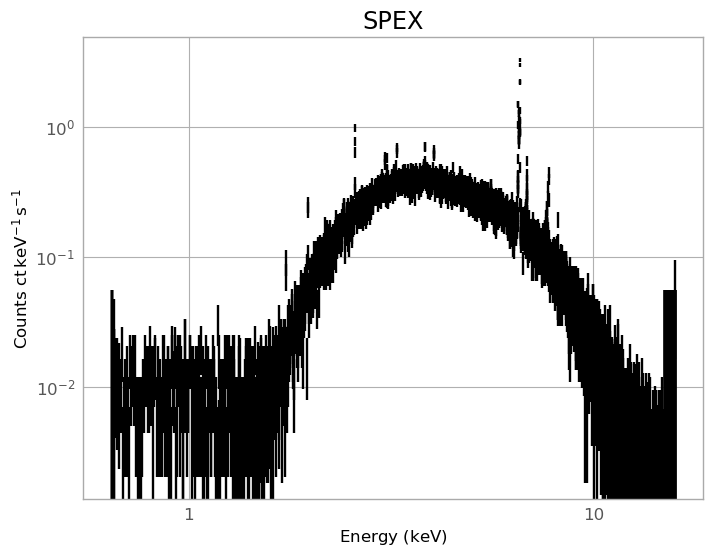

In [40]:
# Optimally bin the spectrum and plot
s.obin(1,1,0.5,15,unit='kev')
s.plot_data(xlog=True,ylog=True)

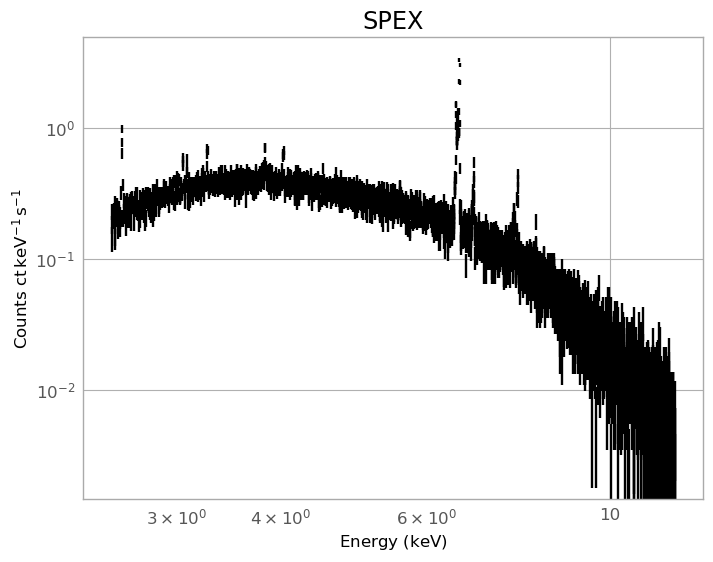

In [41]:
# Ignore parts of the spectrum 
s.ignore(1,1,0.0,2.5,unit='kev')
s.ignore(1,1,12.0,100.,unit='kev')
s.plot_data(xlog=True,ylog=True)

In [42]:
# Set up the model
s.com('reds')
s.com('hot')
s.com('cie')
s.com_rel(1,3,np.array([1,2]))
s.par(1,1,'z',0.0179)
s.par(1,2,'nh',2.12E-3)
s.par_fix(1,2,'t')
s.dist(1,0.0179,'z')
s.par(1,3,'norm',1E+9,thawn=True)
s.par(1,3,'t',4.0,thawn=True)

 You have defined    1 component.
 You have defined    2 components.
 You have defined    3 components.
 Distances assuming H0 =  70.0 km/s/Mpc, Omega_m = 0.300 Omega_Lambda = 0.700 Omega_r = 0.000
Sector       m      A.U.        ly        pc       kpc       Mpc  redshift        cz   age(yr)
----------------------------------------------------------------------------------------------
   1 2.398E+24 1.603E+13 2.535E+08 7.772E+07 7.772E+04   77.7180    0.0179    5366.3 2.468E+08
----------------------------------------------------------------------------------------------



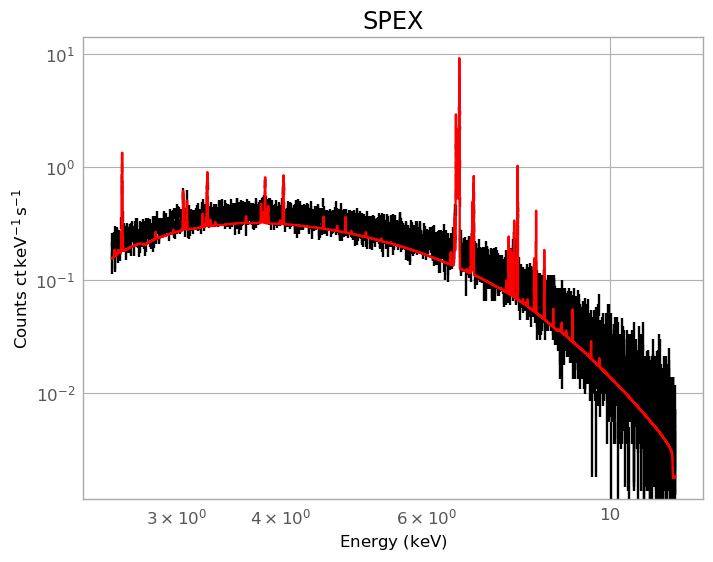

In [43]:
# Calculate the model and plot
s.calc()
s.plot_data(xlog=True,ylog=True)

 fit iter  100                                                   
   17070.5              3  1.000E+09   4.00
 You cannot plot this frame since nothing is defined
 
   12788.5              6  1.130E+09   4.31
 You cannot plot this frame since nothing is defined
 
   12764.5              9  1.116E+09   4.40
 You cannot plot this frame since nothing is defined
 
   12762.2             12  1.110E+09   4.43
 You cannot plot this frame since nothing is defined
 
   12762.0             15  1.108E+09   4.45
 You cannot plot this frame since nothing is defined
 
--------------------------------------------------------------------------------------------------
sect comp mod  acro parameter with unit     value      status    minimum   maximum lsec lcom lpar

   1    1 reds z    Redshift             1.7899999E-02 frozen   -1.0      1.00E+10
   1    1 reds flag Flag: cosmo=0, vel=1  0.000000     frozen    0.0       1.0

   1    2 hot  nh   X-Column (1E28/m**2) 2.1200001E-03 frozen    0.0     

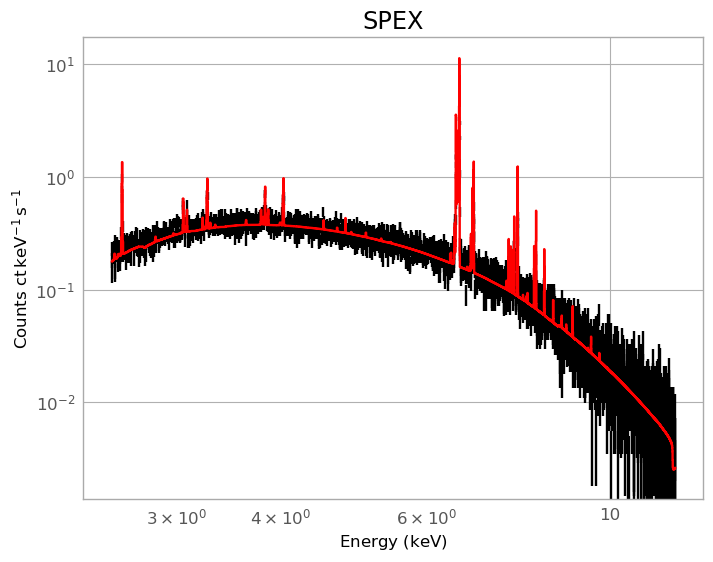

In [44]:
# Fit the model
s.fit()
s.plot_data(xlog=True,ylog=True)

 fit iter  100                                                   
   12762.0              3  1.107E+09   4.45
 You cannot plot this frame since nothing is defined
 
--------------------------------------------------------------------------------------------------
sect comp mod  acro parameter with unit     value      status    minimum   maximum lsec lcom lpar

   1    1 reds z    Redshift             1.7899999E-02 frozen   -1.0      1.00E+10
   1    1 reds flag Flag: cosmo=0, vel=1  0.000000     frozen    0.0       1.0

   1    2 hot  nh   X-Column (1E28/m**2) 2.1200001E-03 frozen    0.0      1.00E+20
   1    2 hot  t    Temperature (keV)    1.0000000E-06 frozen   1.00E-06  1.00E+03
   1    2 hot  rt   T(balance) / T(spec)  1.000000     frozen   1.00E-04  1.00E+04
   1    2 hot  hden Hyd dens (1E20/m**3) 9.9999998E-15 frozen   1.00E-22  1.00E+10
   1    2 hot  fcov Covering fraction     1.000000     frozen    0.0       1.0
   1    2 hot  v    RMS Velocity (km/s)   100.0000     frozen 

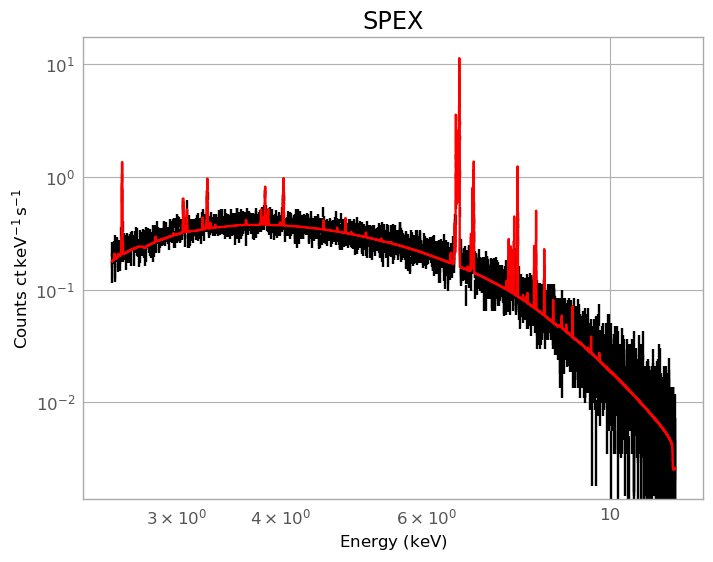

In [45]:
# Now fit with the new database
# s.var_calc(True)
s.fit()
s.plot_data(xlog=True,ylog=True)

In [46]:
s.par_free(1,3,'14')
s.par_free(1,3,'16')
s.par_free(1,3,'18')
s.par_free(1,3,'20')
s.par_free(1,3,'26')
s.par_free(1,3,'28')
s.par_free(1,2,'nh')
s.fit()

 fit iter  100                                                   
   12762.0             10  2.120E-03  1.107E+09   4.45       1.00       1.00
                 1.00       1.00       1.00       1.00
 You cannot plot this frame since nothing is defined
 
   8590.25             20  8.147E-03  1.194E+09   4.05       9.21      0.739
                0.564      0.394      0.366      0.349
 You cannot plot this frame since nothing is defined
 
   8267.55             30  5.229E-03  1.103E+09   4.23       10.5      0.803
                0.661      0.515      0.479      0.379
 You cannot plot this frame since nothing is defined
 
   8254.51             40  6.189E-03  1.111E+09   4.15       11.6      0.807
                0.659      0.517      0.499      0.399
 You cannot plot this frame since nothing is defined
 
   8254.39             50  6.213E-03  1.110E+09   4.15       11.6      0.806
                0.660      0.517      0.501      0.399
 You cannot plot this frame since nothing is defin

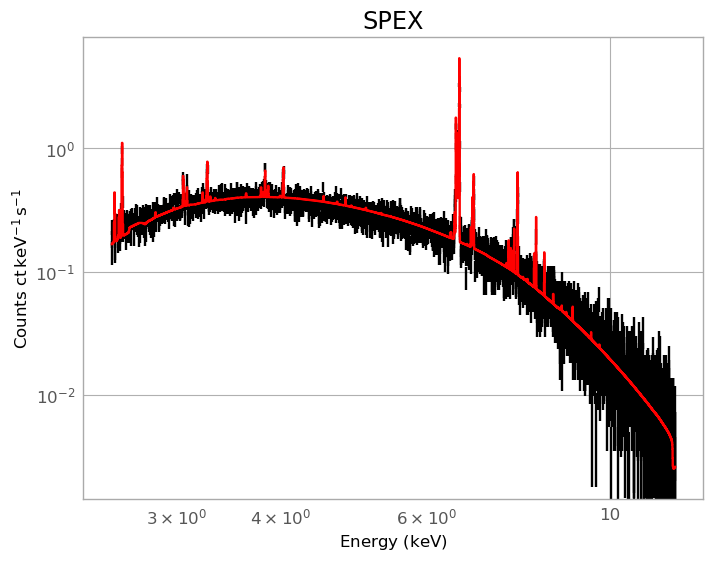

In [47]:
s.plot_data(xlog=True,ylog=True)

In [48]:
s.par_couple(1,3,'it',1,3,'t',1.0)
s.par(1,3,'vrms',150.0,thawn=True)
s.par_free(1,1,'z')
s.fit()

 fit iter  100                                                   
   5019.91             12  1.790E-02  6.223E-03  1.111E+09   4.15       150.
                 11.6      0.806      0.659      0.517      0.502      0.399
 You cannot plot this frame since nothing is defined
 
   3370.90             24  1.755E-02  2.840E-04  1.069E+09   4.46       243.
                 7.10      0.877      0.794      0.726      0.567      0.687
 You cannot plot this frame since nothing is defined
 
   3233.27             36  1.744E-02  7.691E-05  1.088E+09   4.49       217.
                 5.49      0.840      0.780      0.763      0.601      0.818
 You cannot plot this frame since nothing is defined
 
   3225.20             48  1.743E-02  2.942E-04  1.095E+09   4.48       206.
                 5.35      0.820      0.768      0.749      0.598      0.790
 You cannot plot this frame since nothing is defined
 
   3224.49             60  1.742E-02  3.083E-04  1.096E+09   4.48       203.
                 

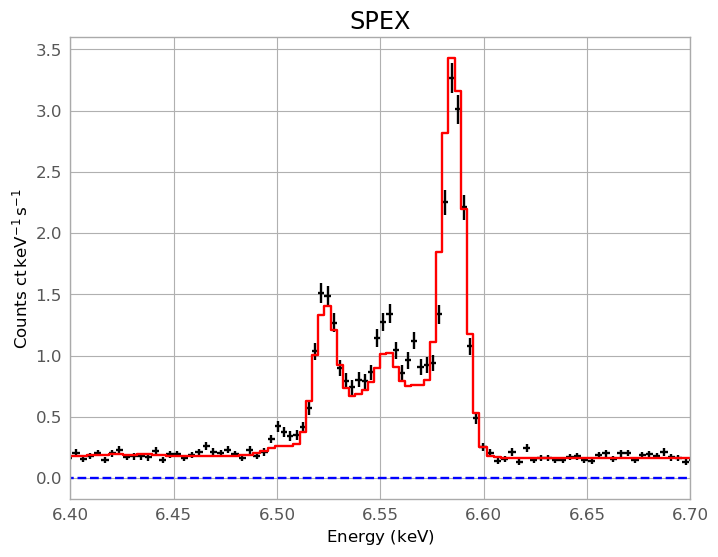

In [49]:
(pl,plt)=s.plot_data(show=False)
plt.xlim(6.4,6.7)
plt.show()